# Обзор данных USDA Quick Stats

Thanks to [CropNet](https://github.com/fudong03/CropNet/)
and [Google Drive](https://drive.google.com/drive/folders/1Js98GAxf1LeAUTxP1JMZZIrKvyJStDgz)

***

## Срез данных
Все данные (2017-2022) всех штатов весят больше 1 тб. Поэтому отберем следующие:
- Данные за *2017-2022* годы.
- Данные по следующим культурам: *Кукуруза*.
- Данные для штатов: *IL, IA, IN, KY, MO, OH*.

***

## Описание
Набор данных USDA Crop Dataset представляет собой данные о сельскохозяйственных культурах, выращиваемых на территории США. Они охватывают 2291 округов.

## Файлы данных
- Структура хранения файлов: `data/raw/USDA/<year>/<crop>/<file_name>`;
- формат названия файла: `USDA_<corn>_County_<year>.csv`;
- пример: `data/raw/USDA/2019/Soybean/USDA_Soybean_County_2019.csv`;

## Формат данных

| Column Name                  | Description                                                           |
|------------------------------|-----------------------------------------------------------------------|
| commodity_desc               | The crop type, i.e., CORN, COTTON, SOYBEANS, or WHEAT                 |
| year                         | Year of the crop information, i.e., 2017, 2018, ..., or 2022          |
| state_ansi                   | The unique code for a U.S. state, e.g.,  "01" for Alabama (AL)        |
| state_name                   | The U.S. state name, e.g., ALABAMA                                    |
| county_ansi                  | The unique code for a U.S. county, e.g., "003" for Baldwin County, AL |
| county_name                  | The U.S. county name, e.g., BALDWIN                                   |
| asd_code                     | Agricultural Statistics District code                                 |
| asd_desc                     | Agricultural Statistics District description                          |
| domain_desc                  | How much area was covered, e.g., TOTAL                                |
| source_desc                  | Description of where the data was sourced, e.g., SURVEY               |
| agg_level_desc               | Description of the region covered, i.e., COUNTY                       |
| PRODUCTION, MEASURED IN BU   | The annual production information.                                    |
| YIELD, MEASURED IN BU / ACRE | The annual yield information.                                         |

***

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
PATH_DATA = Path("../data")
PATH_DATA_USDA = PATH_DATA / "raw/USDA/2019"

In [3]:
# Раньше тут было больше культур
data_corn = pd.read_csv(PATH_DATA_USDA / "corn/USDA_Corn_County_2019.csv")
dict_data = {
    "Corn": data_corn,
}

In [4]:
data_corn.head(2)

,commodity_desc,reference_period_desc,year,state_ansi,state_name,county_ansi,county_name,asd_code,asd_desc,domain_desc,source_desc,agg_level_desc,"PRODUCTION, MEASURED IN BU","YIELD, MEASURED IN BU / ACRE"
0,CORN,YEAR,2019,1,ALABAMA,1,AUTAUGA,40,BLACK BELT,TOTAL,SURVEY,COUNTY,265000.0,165.6
1,CORN,YEAR,2019,1,ALABAMA,3,BALDWIN,50,COASTAL PLAINS & GULF COAST,TOTAL,SURVEY,COUNTY,1094000.0,150.9


In [5]:
print("Corn shape:", data_corn.shape)

Corn shape: (1257, 14)


Избавимся от лишних признаков

In [6]:
for data in dict_data.values():
    data = data.drop(
        data.columns.difference(
            [
                "year",
                "state_ansi",
                "state_name",
                "county_ansi",
                "county_name",
                "PRODUCTION, MEASURED IN BU",
                "YIELD, MEASURED IN BU / ACRE",
            ]
        ),
        axis=1,
        inplace=True,
    )

***
## Изобразим на карте США имеющиеся данные

[FIPS Codes](../obsidian/other/FIPS%20Codes.md) округов (FIPS county codes)
- Формат: `SSCCC`
- Состоят из **5 цифр**:
    - **Первые 2** — код штата.
    - **Последние 3** — код округа внутри штата.
- Пример:
    - `06037` — округ Лос-Анджелес (06 = Калифорния, 037 = Лос-Анджелес).


In [7]:
def get_fips(data: pd.DataFrame) -> pd.Series:
    states_fips = data["state_ansi"].astype(str).str.zfill(2)
    counties_fips = data["county_ansi"].astype(str).str.zfill(3)
    fips = states_fips + counties_fips
    return fips

In [8]:
for data in dict_data.values():
    data["FIPS"] = get_fips(data)

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd


def plot_map(data: pd.DataFrame, title: str) -> None:
    # Загрузка шейпфайлов для штатов и округов
    # https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
    states = gpd.read_file(
        "../resources/USA-map/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    )
    counties = gpd.read_file(
        "../resources/USA-map/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
    )

    # Создаем FIPS-код
    counties["FIPS"] = counties["STATEFP"] + counties["COUNTYFP"]

    # Объединяем данные
    merged = counties.merge(
        data[["FIPS", "YIELD, MEASURED IN BU / ACRE"]], how="left", on="FIPS"
    )

    # Исключаем Аляску, Гавайи и территории
    exclude_states = ["02", "15", "60", "66", "69", "72", "78"]
    merged = merged[~merged["STATEFP"].isin(exclude_states)]
    states = states[~states["STATEFP"].isin(exclude_states)]

    # Рисуем карту
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))

    merged.plot(
        column="YIELD, MEASURED IN BU / ACRE",
        cmap="YlOrBr",
        linewidth=0.2,
        ax=ax,
        edgecolor="0.6",
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Нет данных"},
    )

    # Добавляем границы штатов
    states.boundary.plot(ax=ax, linewidth=1.0, edgecolor="black")

    # Добавляем названия штатов
    states["coords"] = states["geometry"].centroid
    for idx, row in states.iterrows():
        plt.annotate(
            text=row["STUSPS"],  # Почтовый код штата, например, "CA"
            xy=(row["coords"].x, row["coords"].y),
            horizontalalignment="center",
            fontsize=8,
            color="black",
            weight="bold",
        )

    # Оформление
    ax.set_title(title, fontsize=18)
    ax.axis("off")

    plt.tight_layout()
    plt.show()


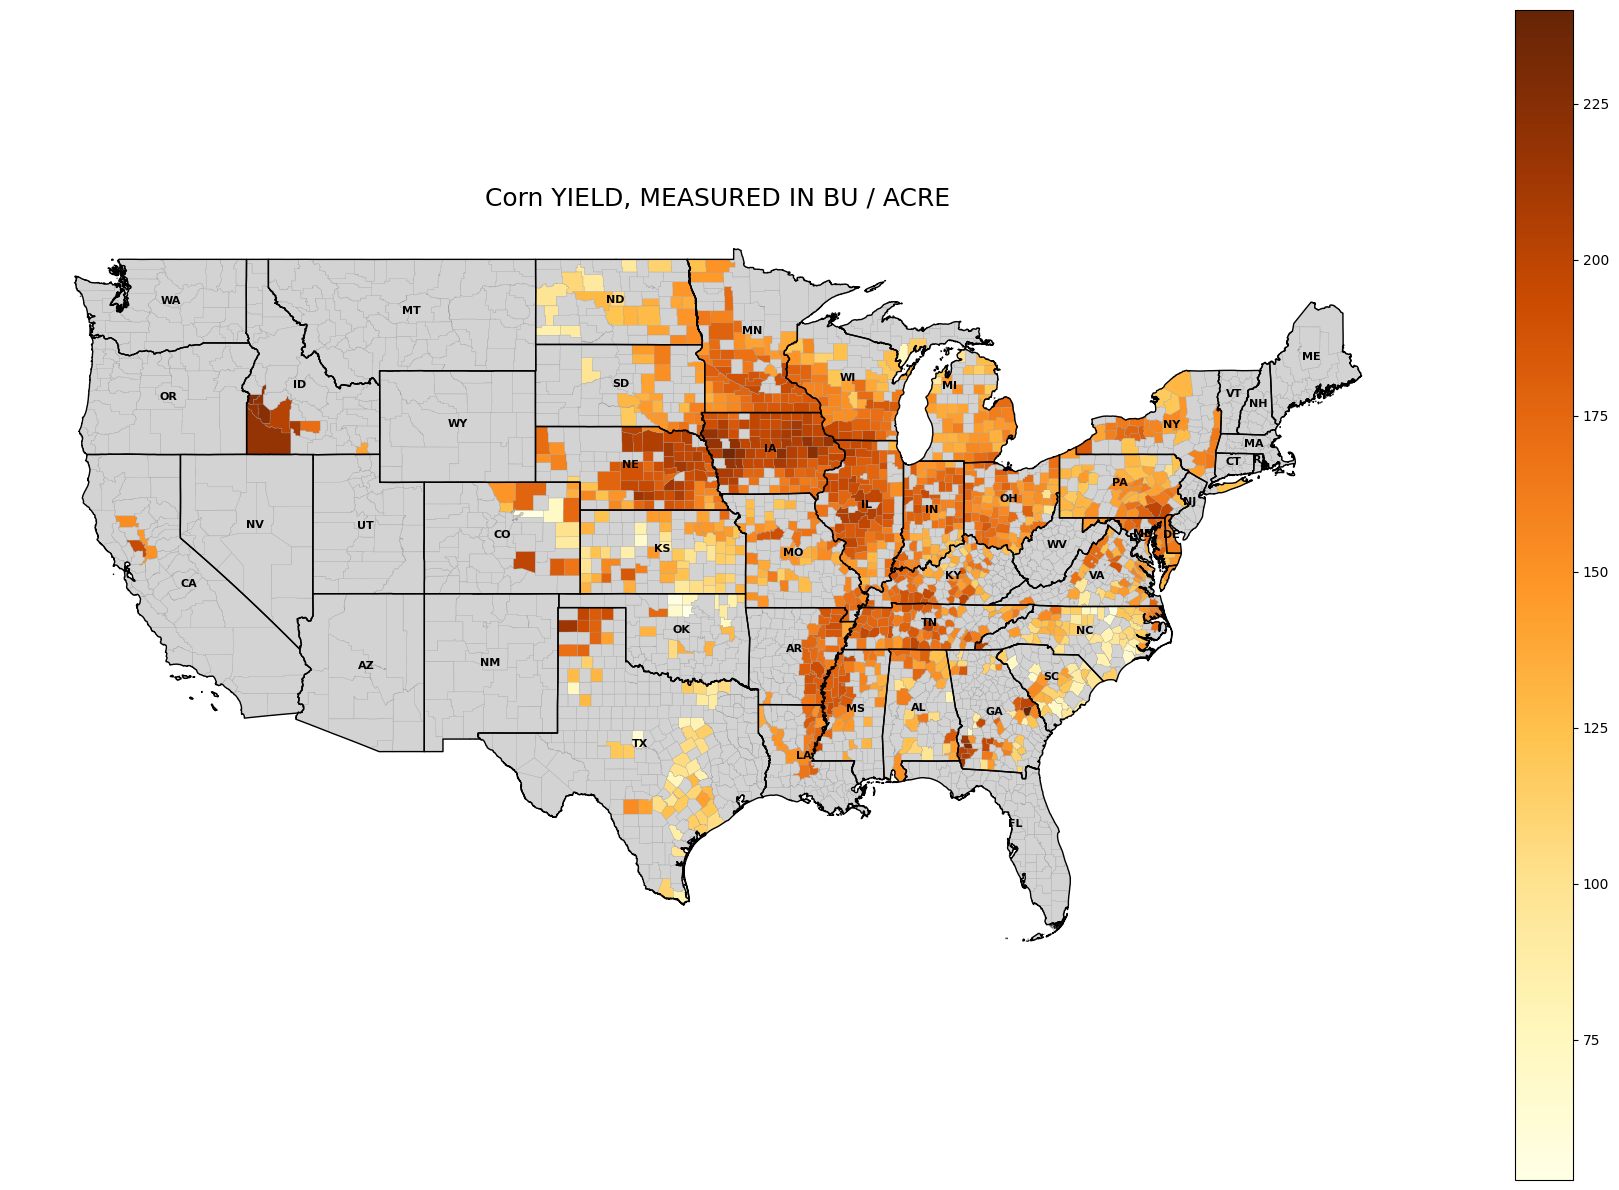

In [10]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for title, data in dict_data.items():
        plot_map(data, f"{title} YIELD, MEASURED IN BU / ACRE")

***

## Гистограммы
Количество записей на штат (что то же самое, что и количество округов в штате, для которых у нас есть данные)

Добавим к штатам их короткие имена

In [11]:
fips_states_counties = pd.read_csv(
    "../data/external/state_and_county_fips_master.csv"
)
fips_states_counties.rename(
    {"state": "short_state_name"}, axis=1, inplace=True
)

In [12]:
data_corn = pd.merge(
    data_corn,
    fips_states_counties[["name", "short_state_name"]],
    how="left",
    left_on="state_name",
    right_on="name",
)
dict_data = {key: data for key, data in zip(dict_data.keys(), [data_corn])}

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_hist(data: pd.DataFrame, title: str):
    plt.figure(figsize=(16, 10))

    # Настройка стиля
    sns.set_theme(style="whitegrid", palette="pastel")

    # Построение гистограммы
    ax = sns.histplot(
        data=data,
        x="short_state_name",
        discrete=True,  # Включаем, если значения категориальные
        shrink=0.8,
        edgecolor="black",
    )

    # Улучшения читаемости
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Штат", fontsize=14)
    ax.set_ylabel("Количество", fontsize=14)
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()


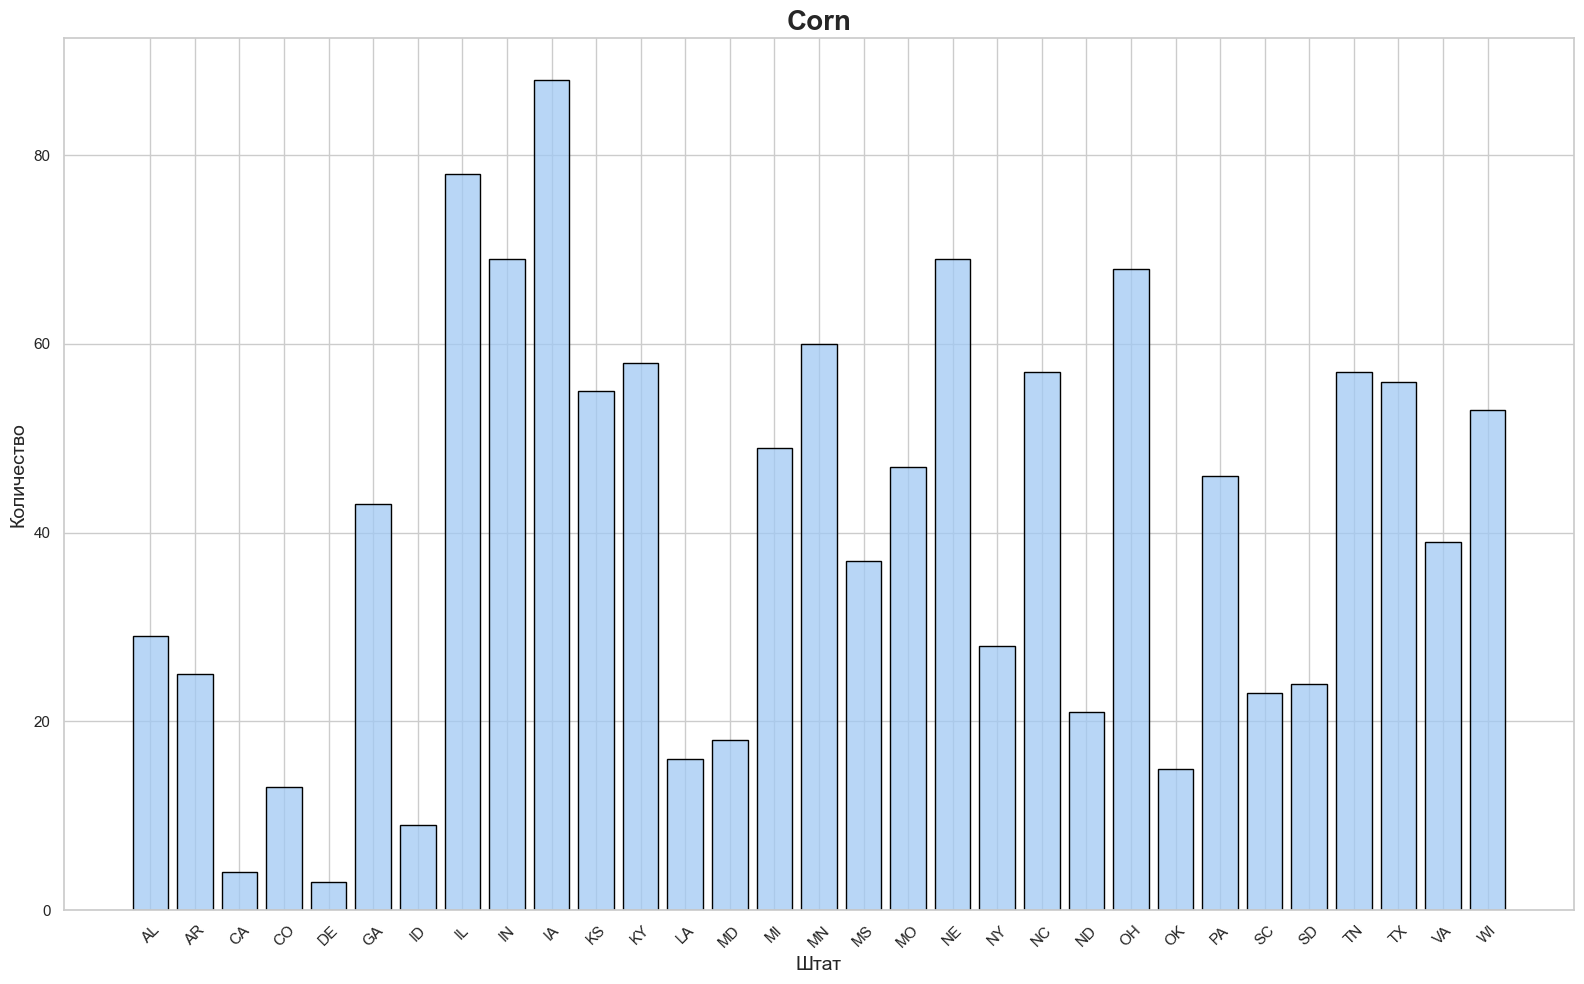

In [14]:
for title, data in dict_data.items():
    plot_hist(data, title)